在不同数据集上测试DVI

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import json
from matplotlib import rc
plt.rcParams['savefig.dpi'] = 300
rc('text', usetex=True)
rc('font', size=15)
rc('xtick', labelsize=10)
rc('ytick', labelsize=10)

import gaussian_variables as gv
import utils as u
import plot_utils as pu
import bayes_layers as bnn
from bayes_models import MLP, PointMLP, AdaptedMLP
from dataset.UCIdataset import UCIDataset
from dataset.Facedataset import FaceDataset

In [3]:
def make_model(hypers):
    if hypers['method'].lower().strip() == 'bayes':
        MLP_factory = MLP

        def prediction(y): return tf.reshape(y.mean[:, 0], [-1])
        loss = bnn.regression_loss
    else:
        MLP_factory = PointMLP

        def prediction(y): return tf.reshape(y.mean[:, 0], [-1])
        loss = bnn.point_regression_loss

    mlp = MLP_factory(hypers['x_dim'], hypers['y_dim'], hypers)
    mlp = AdaptedMLP(mlp)
    mlp.make_placeholders()
    ipt = mlp.placeholders['ipt_mean']
    y = mlp(ipt)

    target = tf.placeholder(tf.float32, [None])
    mlp.placeholders['target'] = target
    global_step = tf.Variable(0, trainable=False, name='global_step')
    loss, logprob, all_surprise = loss(y, target, mlp, hypers, global_step)

    accuracy = tf.reduce_mean(tf.abs(target - prediction(y)))

    return {
        'model': mlp,
        'metrics': {
            'accuracy': accuracy, 'loss': loss,
            'logprob': logprob, 'all_surprise': all_surprise
        },
        'global_step': global_step}


训练和测试的函数。除了“prot”数据集因为数据量过大而使用1000大小的minibatch训练之外，其他都是用全部数据进行训练。

In [4]:
def train_test(
        Xtrain,
        Ytrain,
        Xtest,
        Ytest,
        paras,
        outpath):
    train_no, x_dim = Xtrain.shape
    try:
        test_no, y_dim = Ytest.shape
    except:
        test_no = Ytest.shape
        y_dim = 1

    hypers = {
        "x_dim": x_dim,
        "y_dim": y_dim,
        "hidden_dims": paras["hidden_dims"],
        "nonlinearity": "relu",
        "adapter": {'in':paras['in'],'out':paras['out']},
        "method": "bayes",
        "style": "heteroskedastic",
        "homo_logvar_scale": 2 * np.log(0.2),
        "prior_type": [
            "empirical",
            "wider_he",
            "wider_he"],
        "n_epochs": paras['n_epochs'],
#         "batch_size": 1000,
        "batch_size": train_no,
        "learning_rate": paras['learning_rate'],
        "lambda": 1.0,
        "warmup_updates": {
            'lambda': 14000.0},
        "anneal_updates": {
            'lambda': 1000.0},
        "optimizer": "adam",
        "gradient_clip": 0.1,
        "data_fraction": 1.0,
        "sections_to_run": [
            "train",
            'test']}

    data = [[Xtrain, Ytrain.reshape(-1)],
            [Xtest, Ytest.reshape(-1)]]

    restricted_training_set = u.restrict_dataset_size(
        data[0], hypers['data_fraction'])
    hypers['dataset_size'] = len(restricted_training_set[0])

    device_id = 0
    device_string = u.get_device_string(device_id)
    print(hypers)
    with tf.device(device_string):
        if True:
            model_and_metrics = make_model(hypers)

            train_op = u.make_optimizer(model_and_metrics, hypers)
            sess = u.get_session()
            saver = tf.train.Saver()

            all_summaries = []
            best_valid_accuracy = np.inf

        for epoch in range(1, hypers['n_epochs'] + 1):
            verbose = (epoch % 20 == 0)
            if verbose:
                print("Epoch %i:        " % epoch, end='')

            epoch_summary, accuracies = u.train_valid_test(
                {
                    'train': restricted_training_set,
                    'test': data[1]
                },
                sess, model_and_metrics, train_op, hypers, verbose)
            # dump log file
            all_summaries.append(epoch_summary)

            if epoch % 5000 == 0:
                saver.save(
                    sess,
                    os.path.join(
                        outpath,
                        'model.ckpt'),
                    global_step=epoch)

        with open(os.path.join(outpath, "summaries.json"), 'w') as f:
            json.dump(all_summaries, f, indent=4, cls=u.NumpyEncoder)

    return None

每个数据集运行多次，取结果的平均。

In [5]:
def run_(dataset_name, dataset_path, times, paras):
    np.random.seed(123)

    for time in range(times):
        outpath = os.path.join(dataset_path, str(time))
        if not os.path.exists(outpath):
            os.makedirs(outpath)

        if dataset_name == 'face':
            data = FaceDataset("./dataset", 0.9)
        else:
            data = UCIDataset(dataset_name, 0.9)
        print(
            data.Xtrain.shape,
            data.Ytrain.shape,
            data.Xtest.shape,
            data.Ytest.shape)

        train_test(
            data.Xtrain,
            data.Ytrain,
            data.Xtest,
            data.Ytest,
            paras,
            outpath)

    return None

画出测试集的log-likelihood

In [6]:
def show_(datasets, root_path, times, epoch_list, shape):
    fig = plt.figure()
    for i in range(len(datasets)):
        dataset_name = datasets[i]
        print (dataset_name)
        data_path = os.path.join(root_path, dataset_name)
        b_epoch, e_epoch = epoch_list[i]
        ax = fig.add_subplot(2, 2, i + 1)
        pu.UCI_result_plot(
            dataset_name,
            data_path,
            times,
            ax,
            b_epoch=b_epoch,
            e_epoch=e_epoch,
            shape=shape)
        if i+1 in [1, 3]:
            ax.set_ylabel(shape)
        if i+1 in [3, 4]:
            ax.set_xlabel('Epoch')

    return None

In [7]:
def show_face(root_path, times, b_epoch, e_epoch, shape):
    fig = plt.figure()
    data_path = os.path.join(root_path, dataset_name)
    ax = fig.add_subplot(111)
    test_mean, test_std = pu.UCI_result_plot(
        dataset_name,
        data_path,
        times,
        ax,
        b_epoch=b_epoch,
        e_epoch=e_epoch,
        shape=shape)

    ax.set_ylabel(shape)

    return None

开始运行，这里以“conc”数据集为例，只运行一次，实际项目中是运行20次。

In [8]:
times = 1 #运行次数
paras = {'conc':
             {'in': {"scale": [[1.0]], "shift": [[0.0]]},
              'out': {"scale": [[1.0, 0.1]], "shift": [[0.0, 1.9]]},
              'hidden_dims': [50],
              'learning_rate': 0.1,
              'n_epochs': 2000,
              'epochs': [300, 700]
              },
         'powe':
             {'in': {"scale": [[1.0]], "shift": [[0.0]]},
              'out': {"scale": [[1.0, 0.02]], "shift": [[0.0, -3.5]]},
              'hidden_dims': [50],
              'learning_rate': 0.6,
              'n_epochs': 2000,
              'epochs': [760, 900]
              },
         'yach':
             {'in': {"scale": [[1.0]], "shift": [[0.0]]},
              'out': {"scale": [[1.0, 0.85]], "shift": [[0.0, -1.7]]},
              'hidden_dims': [50],
              'learning_rate': 0.001,
              'n_epochs': 10000,
              'epochs': [8000, 10000]
              },
         'prot':
             {'in': {"scale": [[1.0]], "shift": [[0.0]]},
              'out': {"scale": [[1.0, 0.96]], "shift": [[0.0, -3.5]]},
              'hidden_dims': [100],
              'learning_rate': 0.1,
              'n_epochs': 500,
              'epochs': [5, 20]
              },
         'face':
             {'in': {"scale": [[1.0]], "shift": [[0.0]]},
              'out': {"scale": [[1.0, 0.1]], "shift": [[0.0, -1.0]]},
              'hidden_dims': [50],
              'learning_rate': 0.3,
              'n_epochs': 800,
              'epochs': [225, 400]
              }  
         }

dataset_name = 'conc'  # 数据集名称
root_path = '/home/yunnd/project/result/DVI_test'  # 存储结果的路径
run_(dataset_name, os.path.join(root_path, dataset_name), times, paras[dataset_name])

(927, 8) (927, 1) (103, 8) (103, 1)
{'x_dim': 8, 'y_dim': 1, 'hidden_dims': [50], 'nonlinearity': 'relu', 'adapter': {'in': {'scale': [[1.0]], 'shift': [[0.0]]}, 'out': {'scale': [[1.0, 0.1]], 'shift': [[0.0, 1.9]]}}, 'method': 'bayes', 'style': 'heteroskedastic', 'homo_logvar_scale': -3.2188758248682006, 'prior_type': ['empirical', 'wider_he', 'wider_he'], 'n_epochs': 2000, 'batch_size': 927, 'learning_rate': 0.1, 'lambda': 1.0, 'warmup_updates': {'lambda': 14000.0}, 'anneal_updates': {'lambda': 1000.0}, 'optimizer': 'adam', 'gradient_clip': 0.1, 'data_fraction': 1.0, 'sections_to_run': ['train', 'test'], 'dataset_size': 927}
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 20:         train accuracy = 33.7896 | logprob = -89.9332 | KL term = 1.4956175836030206 test accuracy = 34.9720 | logprob = -92.7892 | KL term = 1.5333909052218178
Epoch 40:         train accuracy = 31.7942 | logprob = -67.4459 | KL term 

Epoch 860:         train accuracy = 13.5610 | logprob = -4.2407 | KL term = 1.9087234052639563 test accuracy = 13.1061 | logprob = -4.2000 | KL term = 1.9087234052639563
Epoch 880:         train accuracy = 13.5610 | logprob = -4.2407 | KL term = 1.9087235369471414 test accuracy = 13.1061 | logprob = -4.2000 | KL term = 1.9087235369471414
Epoch 900:         train accuracy = 13.5610 | logprob = -4.2407 | KL term = 1.9087238003135114 test accuracy = 13.1061 | logprob = -4.2000 | KL term = 1.9087238003135114
Epoch 920:         train accuracy = 13.5611 | logprob = -4.2407 | KL term = 1.9087239319966964 test accuracy = 13.1061 | logprob = -4.2000 | KL term = 1.9087239319966964
Epoch 940:         train accuracy = 13.5611 | logprob = -4.2407 | KL term = 1.9087240636798812 test accuracy = 13.1061 | logprob = -4.2000 | KL term = 1.9087240636798812
Epoch 960:         train accuracy = 13.5611 | logprob = -4.2407 | KL term = 1.9087243270462513 test accuracy = 13.1061 | logprob = -4.2000 | KL term =

Epoch 1820:         train accuracy = 13.5611 | logprob = -4.2407 | KL term = 1.9087351250674218 test accuracy = 13.1061 | logprob = -4.2000 | KL term = 1.9087352567506068
Epoch 1840:         train accuracy = 13.5611 | logprob = -4.2407 | KL term = 1.908735520116977 test accuracy = 13.1061 | logprob = -4.2000 | KL term = 1.908735520116977
Epoch 1860:         train accuracy = 13.5611 | logprob = -4.2407 | KL term = 1.9087359151665317 test accuracy = 13.1061 | logprob = -4.2000 | KL term = 1.9087359151665317
Epoch 1880:         train accuracy = 13.5611 | logprob = -4.2407 | KL term = 1.9087361785329018 test accuracy = 13.1061 | logprob = -4.2000 | KL term = 1.9087361785329018
Epoch 1900:         train accuracy = 13.5611 | logprob = -4.2407 | KL term = 1.9087365735824569 test accuracy = 13.1061 | logprob = -4.2000 | KL term = 1.9087365735824569
Epoch 1920:         train accuracy = 13.5611 | logprob = -4.2407 | KL term = 1.908736836948827 test accuracy = 13.1061 | logprob = -4.2000 | KL ter

画出结果

conc


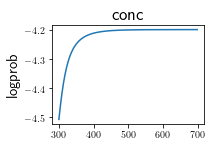

In [9]:
# datasets = [key for key in paras.keys()]
datasets=['conc']
epoch_list = [paras[key]['epochs'] for key in paras.keys()]
show_(datasets, root_path, times, epoch_list, 'logprob')
plt.show()